## 1. Install and Import Required Libraries

In [18]:
# Install missing package for Jupyter (magic command)
%pip install catboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    confusion_matrix, log_loss, brier_score_loss, roc_curve
)
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)

print("All packages loaded successfully!")

Note: you may need to restart the kernel to use updated packages.
All packages loaded successfully!
Note: you may need to restart the kernel to use updated packages.
All packages loaded successfully!


## 2. Load L10 Dataset (Best Performing Window)

In [19]:
# Load the L10 dataset (confirmed as best from LASSO analysis)
df_L10 = pd.read_csv('nba_matchups_with_features_L10.csv')

# Convert date columns
df_L10['date'] = pd.to_datetime(df_L10['date'])

print(f"Dataset loaded: {len(df_L10):,} matchups")
print(f"Seasons: {sorted(df_L10['season'].unique())}")
print(f"\nGames per season:")
print(df_L10['season'].value_counts().sort_index())

Dataset loaded: 5,145 matchups
Seasons: [np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]

Games per season:
season
2022    1290
2023    1288
2024    1285
2025    1282
Name: count, dtype: int64


## 3. Define Features and Create Train/Test Splits

In [20]:
def get_features_L10():
    """
    Return list of base features for L10 window.
    Features are differential (away - home) unless noted.
    """
    features = [
        # Advanced Efficiency Gaps
        'off_rtg_L10_diff',       # Offensive efficiency gap
        'def_rtg_L10_diff',       # Defensive efficiency gap
        'net_rtg_L10_diff',       # Net rating gap
        
        # Shooting Efficiency Gaps
        'efg_pct_L10_diff',       # Effective FG% gap
        '3p_pct_L10_diff',        # 3-point shooting gap
        '3pa_rate_L10_diff',      # 3-point volume gap
        
        # Form/Momentum
        'win_pct_L10_diff',       # Recent win percentage gap
        
        # Ball Control
        'to_pct_L10_diff',        # Turnover rate gap
        'ft_rate_L10_diff',       # Free throw rate gap
        
        # Rebounding & Playmaking
        'oreb_pct_L10_diff',      # Offensive rebounding gap
        'ast_ratio_L10_diff',     # Assist ratio gap
        
        # Defensive Stats
        'stl_pct_L10_diff',       # Steal percentage gap
        'blk_pct_L10_diff',       # Block percentage gap
        
        # Consistency & Momentum (non-window features)
        'pts_std_L10_diff',       # Scoring consistency gap
        'win_streak_diff',        # Win streak differential
        
        # Rest/Fatigue
        'rest_advantage',         # Rest days advantage
        'is_b2b_home',            # Home team back-to-back
        'is_b2b_away'             # Away team back-to-back
    ]
    
    return features

features_L10 = get_features_L10()

print(f"Base features (L10): {len(features_L10)}")
print("\nFeatures:")
for i, f in enumerate(features_L10, 1):
    print(f"  {i:2d}. {f}")

Base features (L10): 18

Features:
   1. off_rtg_L10_diff
   2. def_rtg_L10_diff
   3. net_rtg_L10_diff
   4. efg_pct_L10_diff
   5. 3p_pct_L10_diff
   6. 3pa_rate_L10_diff
   7. win_pct_L10_diff
   8. to_pct_L10_diff
   9. ft_rate_L10_diff
  10. oreb_pct_L10_diff
  11. ast_ratio_L10_diff
  12. stl_pct_L10_diff
  13. blk_pct_L10_diff
  14. pts_std_L10_diff
  15. win_streak_diff
  16. rest_advantage
  17. is_b2b_home
  18. is_b2b_away


In [21]:
def create_train_test_split(df, features, target='win_away'):
    """
    Split data into train (≤2024) and test (2025) sets.
    Returns X_train, X_test, y_train, y_test, dates
    """
    # Verify all features exist
    missing = [f for f in features if f not in df.columns]
    if missing:
        print(f"Warning: Missing features: {missing}")
        features = [f for f in features if f in df.columns]
    
    # Drop any rows with missing values in features or target
    df_clean = df.dropna(subset=features + [target])
    
    # Split by season
    train_mask = df_clean['season'] <= 2024
    test_mask = df_clean['season'] == 2025
    
    X_train = df_clean.loc[train_mask, features].copy()
    X_test = df_clean.loc[test_mask, features].copy()
    y_train = df_clean.loc[train_mask, target].copy()
    y_test = df_clean.loc[test_mask, target].copy()
    
    # Store dates for analysis
    dates_train = df_clean.loc[train_mask, 'date'].copy()
    dates_test = df_clean.loc[test_mask, 'date'].copy()
    
    print(f"Train: {len(X_train):,} games (seasons ≤ 2024)")
    print(f"Test:  {len(X_test):,} games (season 2025)")
    print(f"Train away win rate: {y_train.mean():.1%}")
    print(f"Test away win rate:  {y_test.mean():.1%}")
    
    return X_train, X_test, y_train, y_test, dates_train, dates_test, features

# Create split (2022-2024 for model training, 2025 for final test)
print("=" * 60)
print("L10 Dataset Split:")
print("=" * 60)
X_train, X_test, y_train, y_test, dates_train, dates_test, features = create_train_test_split(
    df_L10, features_L10
)


L10 Dataset Split:
Train: 3,863 games (seasons ≤ 2024)
Test:  1,282 games (season 2025)
Train away win rate: 44.1%
Test away win rate:  45.2%


## 4. Train CatBoost Models with Different Hyperparameters

Test multiple hyperparameter configurations and select the best one based on CV performance. Use randomsearch for speed. 

In [22]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import random

print("=" * 80)
print("HYPERPARAMETER TUNING WITH RANDOMIZED SEARCH")
print("=" * 80)


# Define parameter distribution for random search
param_dist = {
    'depth': randint(2, 8),                    # Range 2-7 (depth of trees)
    'learning_rate': [0.01, 0.05, 0.1],       # Learning rate options
    'iterations': [300, 400, 500, 600, 700, 800, 900, 1000],       # Number of boosting rounds
    'l2_leaf_reg': randint(1, 10)
}

# Create base CatBoost model
base_model = CatBoostClassifier(
    random_state=42,
    loss_function='Logloss',
    eval_metric='AUC',
    task_type='CPU',
    verbose=0
)


# Randomized Search with iterations (tests random combinations)
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=100,  # Number of random combinations to try
    cv=5,       # 5-fold cross-validation on X_train
    scoring='roc_auc',  # Optimize for ROC_AUC to differentiate classes
    n_jobs=-1, 
    random_state=42,
    verbose=1
)

# Fit on model training data ONLY (uses 5-fold CV internally for hyperparameter selection)
random_search.fit(X_train, y_train)

# Get best model and parameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_model_name = f"Best (depth={best_params['depth']}, lr={best_params['learning_rate']}, iter={best_params['iterations']})"

print("\n" + "=" * 80)
print("HYPERPARAMETER SEARCH RESULTS")
print("=" * 80)
print(f"\nBest Parameters Found: {best_params}")
print(f"Best Cross-Validation Log Loss: {-random_search.best_score_:.4f}")  # Negate because scoring is neg_log_loss



HYPERPARAMETER TUNING WITH RANDOMIZED SEARCH
Fitting 5 folds for each of 100 candidates, totalling 500 fits

HYPERPARAMETER SEARCH RESULTS

Best Parameters Found: {'depth': 2, 'iterations': 500, 'l2_leaf_reg': 9, 'learning_rate': 0.01}
Best Cross-Validation Log Loss: -0.6452

HYPERPARAMETER SEARCH RESULTS

Best Parameters Found: {'depth': 2, 'iterations': 500, 'l2_leaf_reg': 9, 'learning_rate': 0.01}
Best Cross-Validation Log Loss: -0.6452


In [23]:
#get predictions
test_probs= best_model.predict_proba(X_test)[:, 1]


## 6. Evaluate Performance


In [24]:

def evaluate_predictions(y_true, probs):
    """
    """
    results_dict = {
        'Metric': [],
        'Score': [],
    }
    
    metrics = [
        ('Accuracy', lambda p: accuracy_score(y_true, p > 0.5)),
        ('AUC-ROC', lambda p: roc_auc_score(y_true, p)),
        ('Log Loss', lambda p: log_loss(y_true, p)),
        ('Brier Score', lambda p: brier_score_loss(y_true, p)),
    ]
    #eg. for accuracy, accuracy_score (metric name, metric function)
    for metric_name, metric_fn in metrics:
        score = metric_fn(probs)

        results_dict['Metric'].append(metric_name)
        results_dict['Score'].append(f"{score:.4f}")
    
    return pd.DataFrame(results_dict)

print("\nTest Set Performance (2025 season):")

evaluation_df = evaluate_predictions(y_test, test_probs)
print("\n" + evaluation_df.to_string(index=False))


Test Set Performance (2025 season):

     Metric  Score
   Accuracy 0.6396
    AUC-ROC 0.6916
   Log Loss 0.6349
Brier Score 0.2220


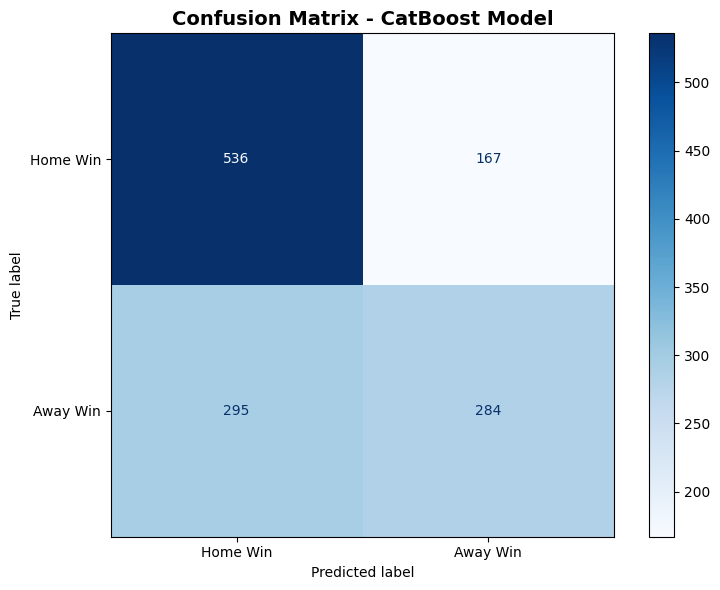


True Negatives:  536
False Positives: 167
False Negatives: 295
True Positives:  284


In [25]:
# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay


cm = confusion_matrix(y_test, test_probs > 0.5)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Home Win', 'Away Win'])
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Confusion Matrix - CatBoost Model', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nTrue Negatives:  {cm[0, 0]}")
print(f"False Positives: {cm[0, 1]}")
print(f"False Negatives: {cm[1, 0]}")
print(f"True Positives:  {cm[1, 1]}")

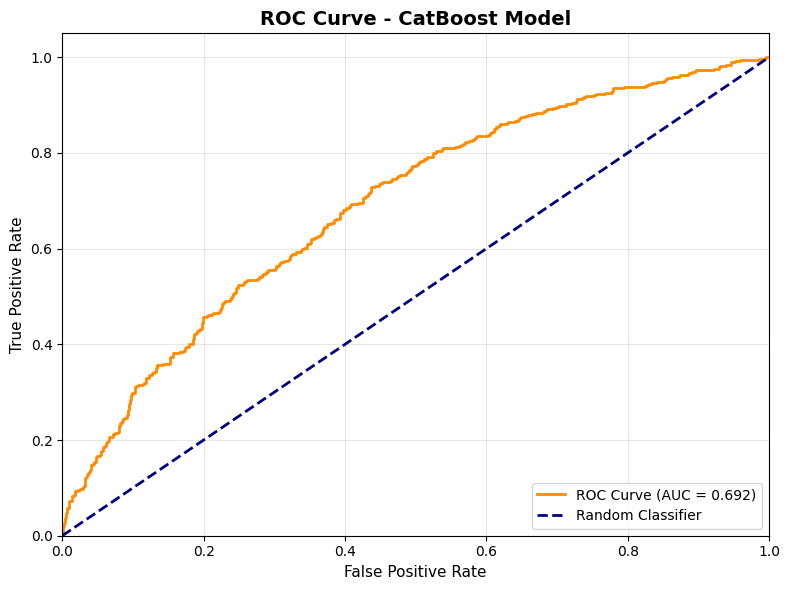


AUC-ROC Score: 0.6916


In [26]:
# ROC Curve


fpr, tpr, thresholds = roc_curve(y_test, test_probs)
roc_auc = roc_auc_score(y_test, test_probs)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=11)
ax.set_ylabel('True Positive Rate', fontsize=11)
ax.set_title('ROC Curve - CatBoost Model', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nAUC-ROC Score: {roc_auc:.4f}")


FEATURE IMPORTANCE

Top 10 Most Important Features:
           Feature  Importance
  net_rtg_L10_diff   39.918158
  off_rtg_L10_diff   15.383822
  win_pct_L10_diff   11.355912
   to_pct_L10_diff    4.953036
  def_rtg_L10_diff    4.797236
 3pa_rate_L10_diff    3.807850
       is_b2b_home    3.173756
   win_streak_diff    2.888693
ast_ratio_L10_diff    2.724017
    rest_advantage    2.642857


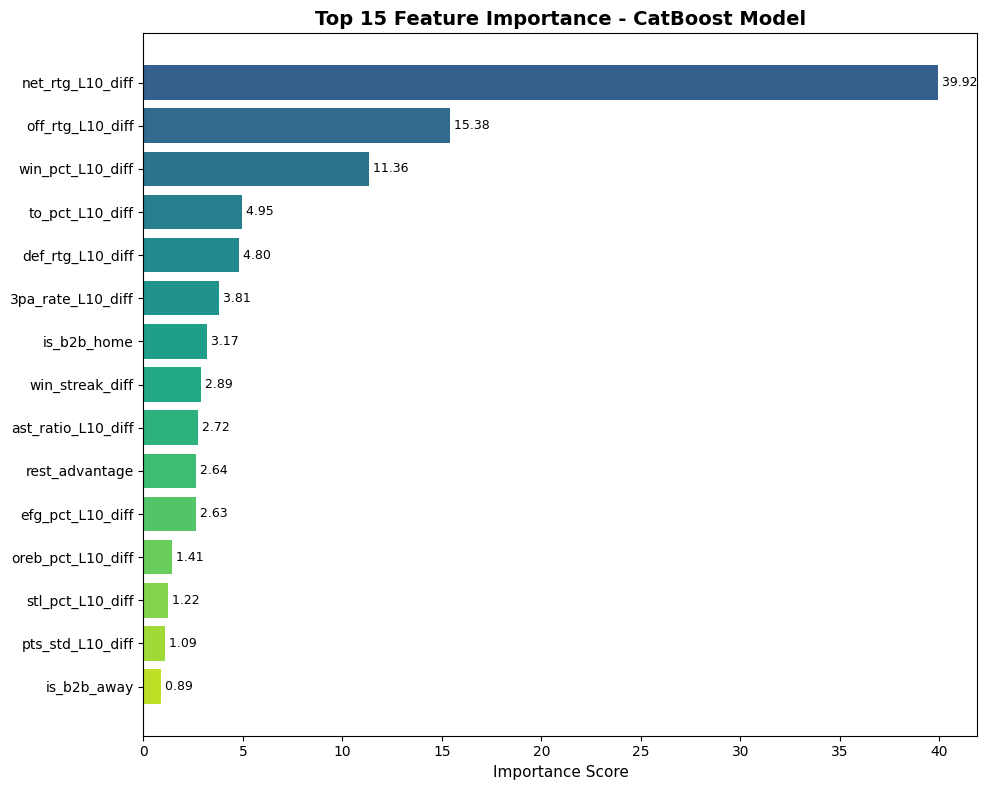


Total Features: 18


In [27]:
# Feature Importance
print("\n" + "=" * 60)
print("FEATURE IMPORTANCE")
print("=" * 60)

# Get feature importances from the best model
feature_importances = best_model.get_feature_importance()
feature_names = features

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

# Display top features
print("\nTop 10 Most Important Features:")
print(importance_df.head(10).to_string(index=False))

# Create visualization
fig, ax = plt.subplots(figsize=(10, 8))
top_n = 15
top_features = importance_df.head(top_n)

colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_features)))
bars = ax.barh(range(len(top_features)), top_features['Importance'].values, color=colors)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'].values, fontsize=10)
ax.set_xlabel('Importance Score', fontsize=11)
ax.set_title(f'Top {top_n} Feature Importance - CatBoost Model', fontsize=14, fontweight='bold')
ax.invert_yaxis()

# Add value labels on bars
for i, (idx, row) in enumerate(top_features.iterrows()):
    ax.text(row['Importance'], i, f" {row['Importance']:.2f}", 
            va='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nTotal Features: {len(importance_df)}")